In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


In [7]:
using ergm.spaces
using ergm.models
using ergm.sampler
using ergm.stats
using LinearAlgebra
using Statistics

n = 30
st = DeltaStats(
    function(G)
        p = sum(G.adjacency) / (n * (n - 1))
        [
            p,
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2)) - p ^ 3
        ]
    end,
    function(G, s, u)
        i, x = u
        p = s[1]
        dp = (x - G[i]) / (n * (n - 1))
        s + [
            dp,
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2)) - (p + dp) ^ 3 + p ^ 3
        ]
    end
)
G0 = DiGraph(rand(Bool, (n, n)))
m = ExponentialFamily(st, zeros(2))

ExponentialFamily(DeltaStats(var"#1#3"(), var"#2#4"(), UndefInitializer(), UndefInitializer()), [0.0, 0.0])

In [8]:
target_Es = [0.010965517241379308, 1.513758154046814e-7]
θ1 = log(target_Es[1] / (1 - target_Es[1])) * n * (n - 1)
update_params(m, [θ1, 1e4])
s = ParallelGibbsSampler(
    G0,
    m,
    10,
    3,
    Threads.nthreads()
)
Gs, ss = sample(s, 10000);

In [10]:
get_params(m)

2-element Vector{Float64}:
 -3916.7170707228133
 10000.0

In [9]:
mean(ss, dims=2)

2×1 Matrix{Float64}:
 0.010946781609192493
 2.513638488833011e-6

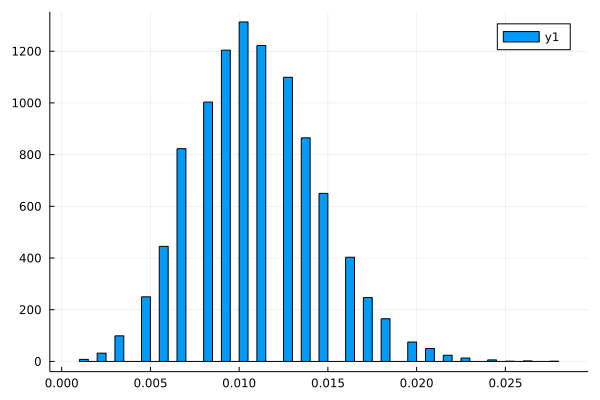

In [17]:
using Plots

histogram(ss[1, :])

In [ ]:
n = 1000
Gs_ER = [DiGraph(convert(Matrix{Bool}, rand(Float64, (n, n)) .< target_Es[1])) for _ ∈ 1:10000];
ss = hcat([get_stats(st, G) for G ∈ Gs_ER]...);

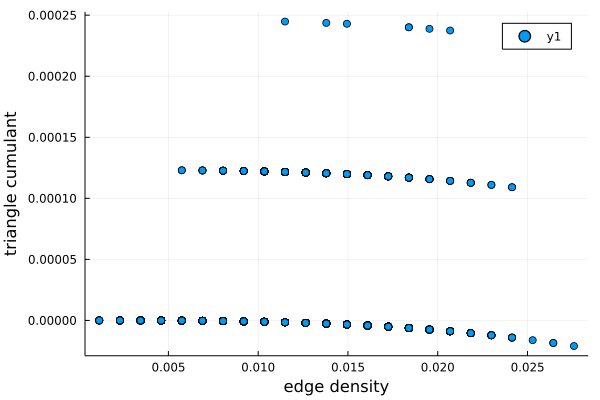

In [15]:
using Plots

scatter(ss[1, :], ss[2, :], xlabel="edge density", ylabel="triangle cumulant")

In [1]:
using Plots

histogram(ss[2, :])

LoadError: ArgumentError: Package Plots not found in current path:
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.


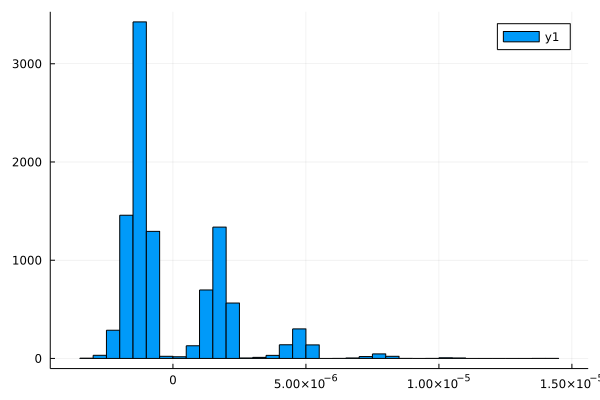

In [142]:
using Plots

histogram(ss[2, :])

In [147]:
minimum(ss[2, :])

-3.409205822122871e-6

In [148]:
max_p = maximum(ss[1, :])
-max_p^3

-3.409205822122871e-6

# 2d head map of cumulant

In [23]:
using ergm.spaces
using ergm.models
using ergm.sampler
using ergm.stats
using LinearAlgebra
using Statistics

n = 30
st = DeltaStats(
    function(G)
        p = sum(G.adjacency) / (n * (n - 1))
        [
            p,
            tr(G.adjacency ^ 3) / (n * (n - 1) * (n - 2))
        ]
    end,
    function(G, s, u)
        i, x = u
        p = s[1]
        dp = (x - G[i]) / (n * (n - 1))
        s + [
            dp,
            3 * (x - G[i]) * dot(G.adjacency[i[2], :], G.adjacency[:, i[1]]) / (n * (n - 1) * (n - 2))
        ]
    end
)
G0 = DiGraph(rand(Bool, (n, n)))
m = ExponentialFamily(st, zeros(2))
samp = ParallelGibbsSampler(
    G0,
    m,
    10,
    3,
    Threads.nthreads()
)

ParallelGibbsSampler(8, GibbsSampler[GibbsSampler(DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), ExponentialFamily(DeltaStats(var"#13#15"(), var"#14#16"(), [0.5241379310344828, 0.14396551724137932], DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0)), [0.0, 0.0]), 10, 3), GibbsSampler(DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), ExponentialFamily(DeltaStats(var"#13#15"(), var"#14#16"(), [0.5241379310344828, 0.14396551724137932], DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0)), [0.0, 0.0]), 10, 3), GibbsSampler(DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), DiGraph(Bool[0 0 … 0 1; 0 0 … 0 1; … ; 0 1 … 0 1; 1 1 … 0 0], 30, 0), ExponentialFamily(DeltaStats(var"#13#15"(), var"#14#16"(), [0.5241379310344828, 0.14396551724137932], DiGraph(Bool[0

In [24]:
θes = map(e -> sign(e) * 10^abs(e), -4:0.5:4)
θts = map(e -> sign(e) * 10^abs(e), -4:0.5:4)
d = zeros((length(θes), length(θts)))

for (i, θe) ∈ enumerate(θes)
    println(i)
    flush(stdout)
    for (j, θt) ∈ enumerate(θts)
        update_params(m, [θe, θt])
        ss = sample(samp, 100)[2]
        d[i, j] = mean((ss[2, :] - ss[1, :].^3) ./ (ss[1, :].^3))
    end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
using ergm.platinum

In [29]:
minimum(d) * 100

-1.0260283724077621

In [6]:
using JLD

save("jlds/a.jld", "θes", θes, "θts", θts, "c", c)

In [2]:
using JLD
@load "jlds/a.jld"

3-element Vector{Symbol}:
 :c
 :θes
 :θts

In [15]:
θes = vcat(θes[1:8], θes[10:end])
θts = vcat(θts[1:8], θts[10:end])
c = [c[1:8, 1:8] c[10:end, 1:8]; c[10:end, 1:8] c[10:end, 10:end]]

16×16 Matrix{Float64}:
 -0.00064761   -0.000172484  -0.0002727    …  -0.000843239  -0.000350578
 -0.000312877  -0.000458443  -0.000149984     -0.000181758  -0.000629621
 -0.000278502  -0.000329824  -0.000131112     -0.000322865  -0.000635485
  1.03916e-5   -0.000115241  -0.00070114      -0.00052822   -0.000555238
 -0.000249583  -0.000661752  -0.000633977     -8.91705e-5   -0.000124135
 -0.000159121  -0.000650292  -0.000471192  …  -0.00021473   -0.000703308
 -0.000624735  -0.000437333  -0.000295851     -0.000492897  -0.00065604
 -0.000216756  -0.000284211   2.41783e-5      -0.000249078  -0.00100489
  9.93764e-6   -0.000452605  -0.000550194     -0.000781335   0.000145502
 -0.000499771  -0.000334253  -0.000389281     -0.00045083   -0.000166677
 -0.000371522  -0.000426276  -0.000890695  …   6.91466e-6   -0.000345493
 -0.00057547   -0.000624062  -0.000778218     -0.000826275  -0.00105135
 -0.000370541  -0.000801481  -3.74825e-5      -0.000736098  -0.000750653
 -0.00022849   -0.000485176  -0

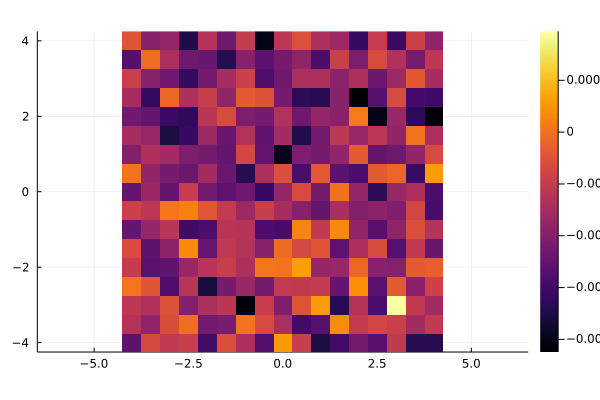

In [6]:
using Plots

gr()
heatmap(-4:0.5:4, -4:0.5:4, c; aspectratio=true)